## Transitions


In this notebook investigation of tessellation nodes importance and transitions between tiles is briefly looked at. 

By making use of visualisation and PageRank algorithm more important nodes are found..

### Transition network

In [1]:
import sys
sys.path.append("../") # Add parent dir to source
import pandas as pd
import numpy as np

import folium
from folium import plugins
from folium.plugins import HeatMap
import datetime
from tqdm.notebook import tqdm # Progress bar


pd.set_option('mode.chained_assignment', None)

In [2]:
from common import haversine_np, RectangularTessellation

In [3]:
df = pd.read_pickle("../processed_data/fully_processed.pkl")

In [4]:
min_lat = 39.76158
max_lat = 40.03603
min_long = 116.19549
max_long = 116.56628

grid_size = 25
tess = RectangularTessellation(min_lon=min_long, 
                               min_lat=min_lat, 
                               max_lon=max_long,
                               max_lat=max_lat,
                               size=grid_size)

In [5]:
m_points = folium.Map(tiles="Stamen Toner")
m_points.fit_bounds([[max_lat, max_long], [min_lat, min_long]])

folium.Choropleth(
    geo_data=tess.get_polygons().to_json(),
    name="choropleth",
    fill_color="YlGn",
    fill_opacity=0.3,
    line_opacity=0.5,
).add_to(m_points)


m_points

## Transition plots

Visualize transitions of taxis from one grid tile to another.

    Hope: Should provide some insight into taxi/traffic flow. 
    How does traffic flow from one part of the city to other.
    
    
Steps to take:

    1) Create trips
    2) From trips extract edges (edge is between two consecutive measurements inside trip)
    

In [6]:
# Look only at Monday again.
monday_data = df[df["time"].dt.day == 4]

In [7]:
# Map data to grid
monday_data["grid_x"], monday_data["grid_y"] = tess.map_to_grid(monday_data["long"], monday_data["lat"])
monday_data.head()

taxi_id                time       long       lat  grid_x  grid_y
188             1 2008-02-04 10:45:00  116.53787  39.91500      23      13
189             1 2008-02-04 10:55:00  116.50839  39.90916      21      13
190             1 2008-02-04 11:05:00  116.50940  39.90679      21      13
191             1 2008-02-04 17:28:00  116.47511  39.91397      18      13
192             1 2008-02-04 17:38:00  116.51175  39.91550      21      14
...           ...                 ...        ...       ...     ...     ...
12085636    10357 2008-02-04 23:28:00  116.43490  39.91582      16      14
12085637    10357 2008-02-04 23:33:00  116.43469  39.92547      16      14
12085638    10357 2008-02-04 23:38:00  116.43861  39.93513      16      15
12085639    10357 2008-02-04 23:43:00  116.45489  39.93229      17      15
12085640    10357 2008-02-04 23:48:00  116.46690  39.93236      18      15

[1801316 rows x 6 columns]

Sample at 5 min rate. Keep first measurement in each 5 min

In [8]:
monday_data_resampled = (
    monday_data
    .set_index("time")
    .groupby(["taxi_id", pd.Grouper(freq="5min")])
    .first()
    .reset_index()
)


### Creating trips

In order not to have too large hops between sequences of coordinates for a taxi it is wise to partition data into trips. This is done by checking if difference between last measurement and current measurement is larger than some number. 

In here a measurement belongs to another trip if the difference between measurements is larger than 15 min.

    Example:
    
     Taxi_ID Time
     1 00:00:00
     1 00:10:00
     1 00:15:00
     1 00:50:00
     2 00:00:00
     2 15:00:00
     
     Would be turned into
     
     Taxi_ID Time Trip_id
     1 00:00:00 1
     1 00:10:00 1
     1 00:15:00 1
     1 00:50:00 2
     2 00:00:00 3
     2 15:00:00 4
     

    

In [9]:
def partition_data_to_trips(df, gap_size = 15):
    """
    We have a new trip if last measurement difference from previous is greater than gap_size minutes.
    
    Note: This code is ugly and slow... Should think of a better split-apply-combine routine for this.
    Otherwise it could be ran in parallel for each taxi and then just shift trip ids based on max for 
    previous taxi
    
    Return a new dataframe with trip ids added.
    """
    current_trip_id = 0
    max_time_diff = datetime.timedelta(minutes=gap_size)
    
    # Collect changed dataframes. 
    taxi_partitions = []
    for k,v in tqdm(df.groupby("taxi_id"), 
                    total=len(df["taxi_id"].unique())):
        
        # Get time differences with previous measurements
        v["time_diff"] = v["time"] - v.shift()["time"]
        
        # New taxi id belongs to a new trip.
        current_trip_id += 1 
        
        # Create a list for trip ids
        trip_ids = [current_trip_id]
        
        for row_nr in range(1, len(v)):
            # Calculate time_difference
            time_diff = v.iloc[row_nr]["time_diff"]
            # If difference is greater than max, then this measurement belongs to new trip
            if time_diff > max_time_diff:
                current_trip_id += 1
            trip_ids.append(current_trip_id)
        v["trip_id"] = trip_ids
        
        taxi_partitions.append(v)
            
    return pd.concat(taxi_partitions).drop("time_diff", axis=1)

#monday_data_partitoned = partition_data_to_trips(monday_data_resampled)

In [10]:
def partition_data_to_trips_efficient(df, gap_size = 15):
    """
    Efficient version of the function above..
    
    
    1) Create a new column. The value in new column is 1 
        if the time diff from previous measurement is larger than gap_size, otherwise 0.
    2) Each group's first row has 1.
    
    3) Do cumulative sum based on two above criteria.
        1 if new trip
        1 if gap larger than gap_size
    
    """
    
    max_time_diff = datetime.timedelta(minutes=gap_size)
    df_copy = df.copy()
    df["prev_time"] = df_copy.groupby("taxi_id")["time"].shift()
    df["gap_greater"] = (df["time"] - df["prev_time"]) > max_time_diff 
    df["new_trip"] = pd.isna(df["prev_time"]) | df["gap_greater"]
    
    df["trip_id"] = df["new_trip"].cumsum()
    
    return df.drop(["prev_time", "gap_greater", "new_trip"], axis=1)
    
    
efficiently_partitioned = partition_data_to_trips_efficient(monday_data_resampled)
    

In [11]:
efficiently_partitioned.head()

taxi_id                time       long       lat  grid_x  grid_y  trip_id
0        1 2008-02-04 10:45:00  116.53787  39.91500      23      13        1
1        1 2008-02-04 10:55:00  116.50839  39.90916      21      13        1
2        1 2008-02-04 11:05:00  116.50940  39.90679      21      13        1
3        1 2008-02-04 17:25:00  116.47511  39.91397      18      13        2
4        1 2008-02-04 17:35:00  116.51175  39.91550      21      14        2

In [12]:
# Create edge network on all data of movement
#monday_data_partitoned.head()

In [13]:
#monday_data_partitoned.equals(efficiently_partitioned)
# I found that it is exactly the same..


### Improved..
Seems like the efficient version gives the same result as inefficient one. 

This is just a small additional win for me.. Down from 5 minutes to seconds.

In [14]:
efficiently_partitioned

taxi_id                time       long       lat  grid_x  grid_y  \
0              1 2008-02-04 10:45:00  116.53787  39.91500      23      13   
1              1 2008-02-04 10:55:00  116.50839  39.90916      21      13   
2              1 2008-02-04 11:05:00  116.50940  39.90679      21      13   
3              1 2008-02-04 17:25:00  116.47511  39.91397      18      13   
4              1 2008-02-04 17:35:00  116.51175  39.91550      21      14   
...          ...                 ...        ...       ...     ...     ...   
1335222    10357 2008-02-04 23:25:00  116.43490  39.91582      16      14   
1335223    10357 2008-02-04 23:30:00  116.43469  39.92547      16      14   
1335224    10357 2008-02-04 23:35:00  116.43861  39.93513      16      15   
1335225    10357 2008-02-04 23:40:00  116.45489  39.93229      17      15   
1335226    10357 2008-02-04 23:45:00  116.46690  39.93236      18      15   

         trip_id  
0              1  
1              1  
2              1  
3              2  
4              2  
...          ...  
1335222    49420  
1335223    49420  
1335224    49420  
1335225    49420  
1335226    49420  

[1335227 rows x 7 columns]

In [15]:
efficiently_partitioned[["prev_x", "prev_y"]] = efficiently_partitioned.groupby("trip_id").shift(-1)[["grid_x", "grid_y"]]
subs = efficiently_partitioned[["taxi_id", "time", "grid_x", "grid_y", "prev_x", "prev_y", "trip_id"]].dropna()

In [16]:
subs["prev_x"] = subs["prev_x"].astype(int)
subs["prev_y"] = subs["prev_y"].astype(int)

### Creating graph

Using the trip discretization we got from previous step and tessellation we can finally create some graphs!

First lets take all Monday's data and create a first graph

In [17]:

edge_counts = (subs
               .groupby(["prev_x", "prev_y", "grid_x", "grid_y"])
               .count()
               .rename(columns={"trip_id":"count"})[["count"]]
               .reset_index()
              )


In [18]:
graph_df = pd.DataFrame({
    "source": edge_counts["prev_x"]*grid_size + edge_counts["prev_y"],
    "target": edge_counts["grid_x"]*grid_size + edge_counts["grid_y"],
    "weight": edge_counts["count"]
})


In [19]:
graph_df.head()

source  target  weight
0       0       0     168
1       0       4       1
2       0      25       1
3       0      50       3
4       0      75       3

In [20]:

ind = pd.MultiIndex.from_product([[i for i in range(grid_size**2)], 
                                [i for i in range(grid_size**2)]], 
                               names=["source", "target"])

gaps_filled = (graph_df
               .set_index(["source", "target"])
               .join(pd.DataFrame(index=ind), how="right")
               .fillna(0)
               .reset_index())
gaps_filled["weight"] = gaps_filled["weight"].astype(int)

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

In [22]:
G = nx.from_pandas_edgelist(gaps_filled)

In [23]:
def nr_to_pos(nr, grid_size: int) -> tuple[int, int]:
    """
    Turn grid nr back to x,y.
    
    formula is nr // grid_size for x coordinate
               nr % grid_size for y coordinate
    """
    x = np.floor_divide(nr, grid_size)
    y = np.remainder(nr, grid_size)    
    
    return np.array(list(zip(x, y)))
    

In [24]:
positions = nr_to_pos([i for i in range(grid_size**2)], grid_size)

In [25]:
G = nx.from_pandas_edgelist(gaps_filled)

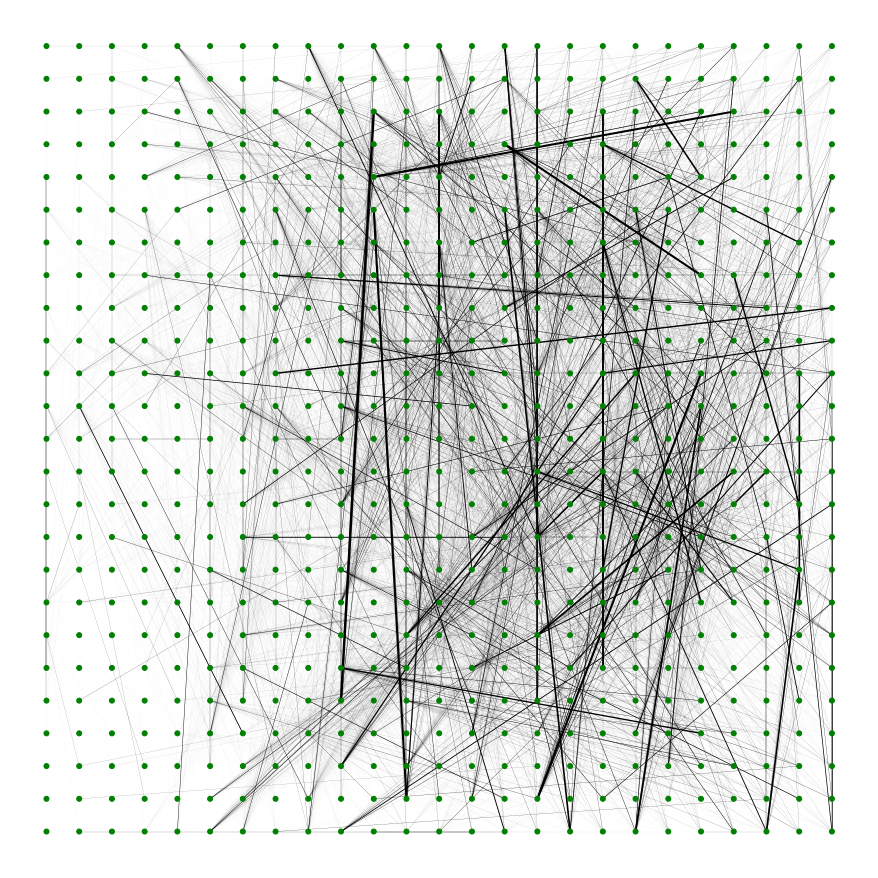

In [26]:
plt.figure(figsize=(12,12)) 


nx.draw(G, pos=positions, 
        node_color="green", 
        width=gaps_filled["weight"]/gaps_filled["weight"].max()*8,
       node_size=[25 for i in range(grid_size**2)])


### Results

We can see that even though our trips limit between 2 nodes is 15 minutes, there are still many edges which cross many nodes


### Pagerank

For fun, lets try to find pagerank of our nodes..
Pagerank is calculated on directed graph, but plot is drawn using undirected as it is much faster here compared to directed graph drawing.

In [27]:
D=nx.DiGraph()
D.add_weighted_edges_from(zip(gaps_filled["source"], gaps_filled["target"], gaps_filled["weight"]))

In [28]:
pr = nx.pagerank(D, alpha=0.95)

In [29]:
weights_from_pr = [pr[i] for i in range(grid_size**2)]

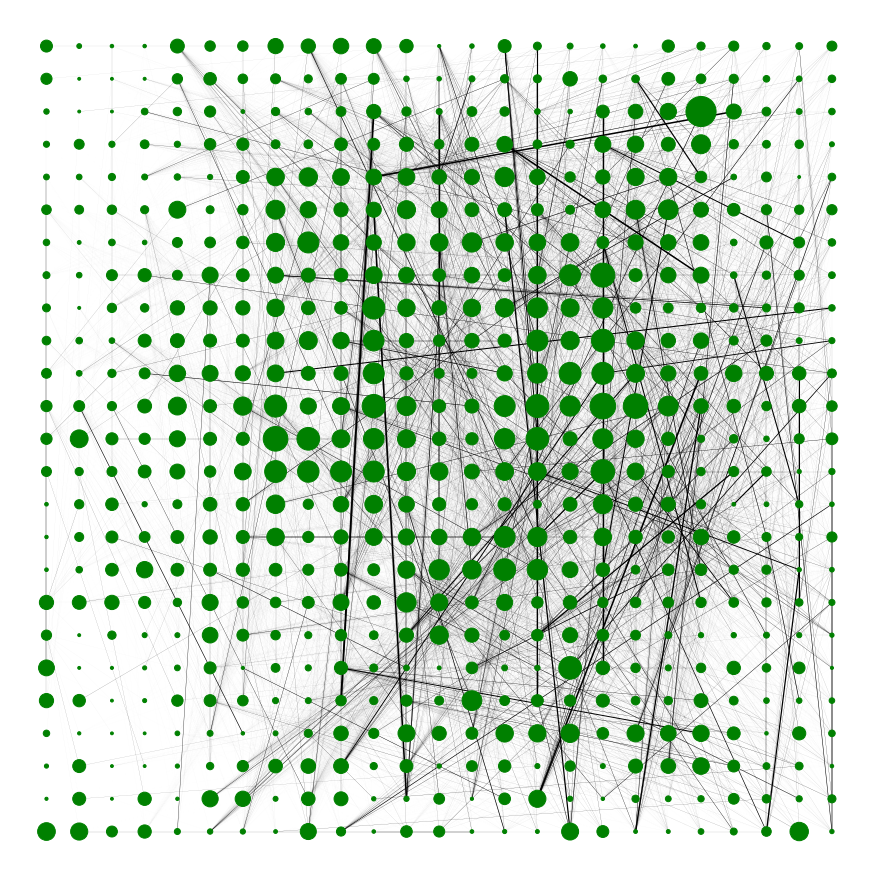

In [30]:
plt.figure(figsize=(12,12)) 


nx.draw(G, pos=positions, 
        node_color="green", 
        width=gaps_filled["weight"]/gaps_filled["weight"].max()*6,
       node_size=np.array(weights_from_pr)*100000,
        
       )

#### Interpretation

Pagrank is a measure of importance for different nodes. The larger the nodes are, the more important they are.

The importance of a node depends on its incoming nodes and how important the incoming nodes themselves are.

We can see that more important nodes are in the middle of the city. Also we note that large point at the top-right of the plot. This should be the "train-station" we saw in earlier analysis.

We get slightly differing results by playing around with the damping factor - alpha.

    If alpha is 0.95, then it is 1 - 0.95 probability to jump into a random node. 
    Otherwise the probability of choosing next node depends the outgoing edge weights.
    
    
We can see that some corners have rather high probability and weights. This might be due to self-edges. We get node transition to itself when the car is not moving. Lets see what happens if we remove all edges to the node itself:

In [31]:
copy_gaps = gaps_filled.copy()
# Set all self-edges to 0
copy_gaps["weight"] = copy_gaps.apply(lambda x: x["weight"] if x["source"] != x["target"] else 0, axis=1)

In [32]:
D=nx.DiGraph()
D.add_weighted_edges_from(zip(copy_gaps["source"], copy_gaps["target"], copy_gaps["weight"]))
pr = nx.pagerank(D, alpha=0.90)

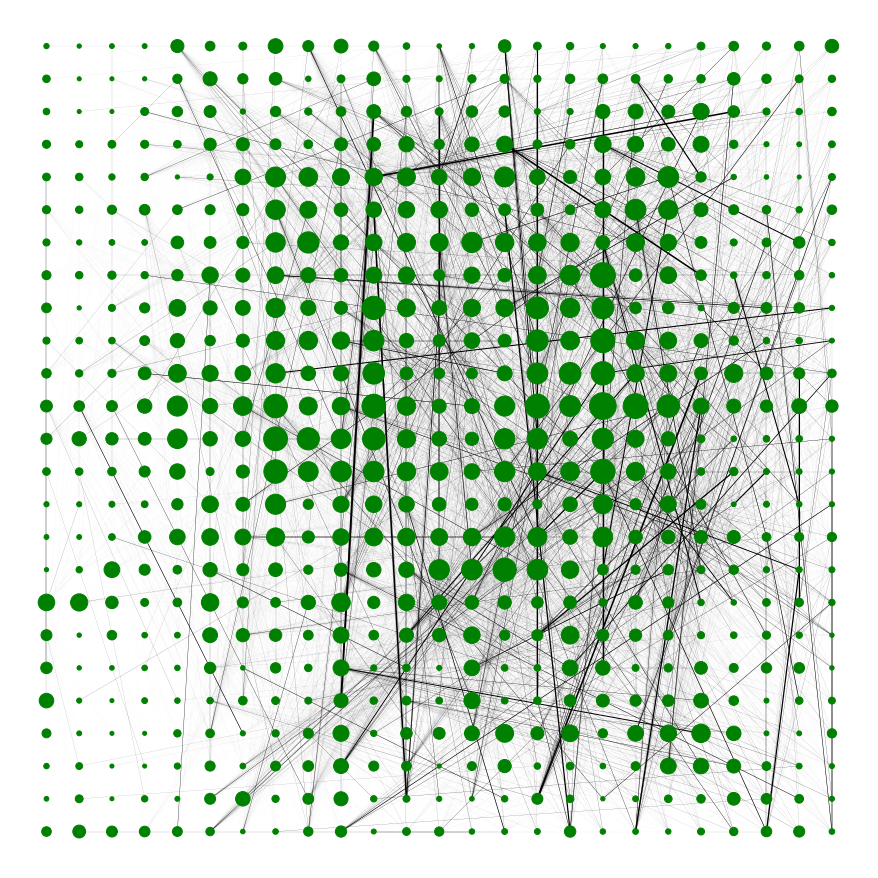

In [33]:
weights_from_pr = [pr[i] for i in range(grid_size**2)]

plt.figure(figsize=(12,12)) 


nx.draw(G, pos=positions, 
        node_color="green", 
        width=gaps_filled["weight"]/gaps_filled["weight"].max()*6,
       node_size=np.array(weights_from_pr)*100000, 
       )

We see a lot less probability assignet to corners. Also, we see that the "train-station" node has gotten smaller as well.

This plot pretty well shows the most popular locations of taxis. Also it shows locations of the tessellation which no taxi really visits.


### Pagerank continued.. Different hours of the day

Lets partition day by 3 hours and plot above graphs again..
    
    00:00 - 03:00
    03:00 - 06:00
    ...
    
Normalize sizes of nodes according to the total number of logged gps signals of max partition.

Normalizing constant is logs_in_this_partition / max_logs_in_partition


Note: I'm not running the code as it is creating figures.. I'll instead display final .gif
   

In [34]:

three_hour_partitioning = (subs
                           .set_index("time")
                           .groupby([pd.Grouper(freq="3h"), "prev_x", "prev_y", "grid_x", "grid_y"])
                           .count()
                           .rename(columns={"trip_id":"count"})[["count"]]
                           .reset_index())



max_edge_count = three_hour_partitioning["count"].max()

In [35]:
max_signals = three_hour_partitioning.groupby("time").sum()["count"].max()

In [36]:

ind = pd.MultiIndex.from_product([[i for i in range(grid_size**2)], 
                                [i for i in range(grid_size**2)]], 
                               names=["source", "target"])

positions = nr_to_pos([i for i in range(grid_size**2)], grid_size)


if False:
    for i, (k, part_df) in enumerate(three_hour_partitioning.groupby("time")):



        count_signals = part_df["count"].sum()

        graph_df = pd.DataFrame({
            "source": part_df["prev_x"]*grid_size + part_df["prev_y"],
            "target": part_df["grid_x"]*grid_size + part_df["grid_y"],
            "weight": part_df["count"]
        })


        # Fill gaps. Add 0 nodes..
        gaps_filled = (graph_df
                       .set_index(["source", "target"])
                       .join(pd.DataFrame(index=ind), how="right")
                       .fillna(0)
                       .reset_index())

        # Set self-transitions to 0
        gaps_filled["weight"] = gaps_filled["weight"].astype(int)
        gaps_filled["weight"] = gaps_filled.apply(
            lambda x: x["weight"] if x["source"] != x["target"] else 0, axis=1)

        D=nx.DiGraph()
        D.add_weighted_edges_from(zip(gaps_filled["source"], gaps_filled["target"], gaps_filled["weight"]))
        pr = nx.pagerank(D, alpha=0.95)

        weights_from_pr = [pr[i] for i in range(grid_size**2)]

        # Node size normalizing 
        normalizing_constant = count_signals/max_signals
        #print(normalizing_constant)


        plt.figure(figsize=(12,12)) 

        nx.draw(G, pos=positions, 
                node_color="green", 
                width=gaps_filled["weight"]/max_edge_count*8,
                # Multiply node size by also by a normalizing constant
               node_size=np.array(weights_from_pr)*50000*normalizing_constant, 
               )

        plt.title(f"From {k} to {k + datetime.timedelta(hours=3)}")
        #plt.show()
        plt.savefig(f"monday_pr_{i+1}.png",dpi=200, bbox_inches="tight")

<img src="monday_pagerank.gif" width="800" align="center">

### Results

If nothing else, we can see more activity during the day from the liine widths. During nighttime central nodes lose a little bit of importance with the probability being spread more around all Beijing. In the morning we also see more spike in top-right, which should be the way to train station and airport.

### Potential improvements

First of all, should normalize sizes of nodes according to activity. This can be done by the number of active taxis during that time period.


At the moment measurements can hope over grid tiles. In reality we do not teleport. There are two options to solve this:

    1) Change data - add interpolations and up the sampling frequency
    2) Add additional edges inside trips, which would contain the connecting tile(s).
           This can be done with interpolations.
           
